# <center> TAPE
### <center> Visualizar BERT embeddings

In [1]:
import numpy as np
import pandas as pd
import altair  as alt
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

# Cargar datos

In [2]:
#df = pd.read_csv("../data/macros.csv", index_col="Uniprot Code")
df = pd.read_excel("../data/macros&covid_with_domains.xlsx", index_col="Uniprot Code")
df.head()

,Tipo de Macro,Secuencia,uniprot,Unnamed: 4,domain,accession,hit_start,hit_end,domain.1,accession.1,...,Unnamed: 150,Unnamed: 151,Unnamed: 152,Unnamed: 153,Unnamed: 154,Unnamed: 155,Unnamed: 156,Unnamed: 157,Unnamed: 158,Unnamed: 159
Uniprot Code,,,,,,,,,,,,,,,,,,,,,
O28751,AF-1521-like,MEVLFEAKVGDITLKLAQGDITQYPAKAIVNAANKRLEHGGGVAYA...,O28751,NaN,MACRO,PS51154,1,192,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D3RWS7,AF-1521-like,MEVEVVRELEMDKLKVKLAGGDITKYPAEAIVNAANKYLEHGGGVA...,D3RWS7,NaN,MACRO,PS51154,3,193,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D2RH24,AF-1521-like,MVVKKFGSVEVVLEKGDITKYPAEAIVNAANKYLEHGGGVALAIAK...,D2RH24,NaN,MACRO,PS51154,1,191,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A0F7ICE9,AF-1521-like,MKPEVVLRFSGVEVRLVQGDITKYPAEAIVNAANRHLEHGGGVAYA...,A0A0F7ICE9,NaN,MACRO,PS51154,1,194,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A075LQ95,AF-1521-like,MNLTELTFGNLTFKLAQGDITKLPAEAIVNAANKYLEHGGGVALAI...,A0A075LQ95,NaN,MACRO,PS51154,1,190,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
labels = df["Tipo de Macro"].values
codes  = df["uniprot"].values
embs   = np.load("macros_bert.npy")
embs.shape

(176, 768)

## Visualización con reducción dimenssional (PCA, tSNE y UMAP)

In [4]:
def plot_multidimensional(x, y, method):

    # Libraries
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    import umap
    
    # Compute
    if method=="pca":    comps = PCA().fit_transform(x)
    elif method=="tsne": comps = TSNE().fit_transform(x)
    elif method=="umap": comps = umap.UMAP().fit_transform(x)
    
    df_dimRed = pd.DataFrame({'Componente 1': comps[:, 0],  'Componente 2': comps[:, 1], "y": y})

    
    # Plot
    selection = alt.selection_multi(fields=['y'])
    color = alt.condition(selection, alt.Color('y:N', legend=None), alt.value('lightgray'))

    base = alt.Chart(df_dimRed).add_selection(selection)

    scatter = base.mark_circle(size=60).encode(
        x="Componente 1", y="Componente 2", color=color, tooltip="y"
    ).properties( width=400, height=400).interactive()

    legend = base.mark_rect().encode(
        y=alt.Y('y:N', axis=alt.Axis(orient='right')),
        color=color
    )

    return scatter | legend

In [5]:
plot_multidimensional(embs, df["Tipo de Macro"], method="pca")

alt.HConcatChart(...)

In [6]:
plot_multidimensional(embs, df["Tipo de Macro"], method="tsne")

alt.HConcatChart(...)

In [7]:
plot_multidimensional(embs, df["Tipo de Macro"], method="umap")

alt.HConcatChart(...)

## Clustering jerárquico (Agglomerative clustering con distancias coseno y euclidea)

### Linkage methods
- `single`
- `complete`
- `average`
- `weighted`
- `centroid`
- `median`
- `ward`

### Distancias (metric)
- `braycurtis`
- `canberra`
- `chebyshev`
- `cityblock`
- `correlation`
- `cosine`
- `dice`
- `euclidean`
- `hamming`
- `jaccard`
- `jensenshannon`
- `kulsinski`
- `mahalanobis`
- `matching`
- `minkowski`
- `rogerstanimoto`
- `russellrao`
- `seuclidean`
- `sokalmichener`
- `sokalsneath`
- `sqeuclidean`
- `yule`

In [46]:
def hierarchical_clustering(embs, labels, codes,
                            distance="euclidean", # cosine
                            method='ward', # average
                            threshold=0,
                            orientation="top", # left
                            figsize=(8,32)):
    
    from scipy.cluster import hierarchy
    
    links = hierarchy.linkage(embs, method, distance)
    
    plt.figure(figsize=figsize)
    hierarchy.dendrogram(links,
                         color_threshold=threshold,
                         above_threshold_color='grey',
                         labels=(labels + " - " + codes),
                         orientation=orientation,
                         leaf_font_size=10)
    plt.title("Hierarchical Clustering ("+distance+" distance)")
    
    ax = plt.gca()
    if orientation=="top":
        plt.ylabel("Distance ("+distance+")")
        plt.axhline(threshold, color='k', linestyle='--')
        tick_lbls = ax.get_xmajorticklabels()
    else:
        plt.xlabel("Distance ("+distance+")")
        plt.axvline(threshold, color='k', linestyle='--')
        tick_lbls = ax.get_ymajorticklabels()
    
    # COLOR LABELS
    label_uniques = list(set(labels))
    palette = plt.cm.get_cmap("tab20", len(label_uniques))
    num=0
    for lbl_cod in tick_lbls:
        lbl = lbl_cod.get_text().split(" - ")[0]
        #print(type(lbl), lbl.get_text(), labels_serie.values[num])
        val=label_uniques.index(lbl)
        lbl_cod.set_color(palette(val))
        num+=1
    
    plt.show()
    
    return hierarchy.to_tree(links, False)

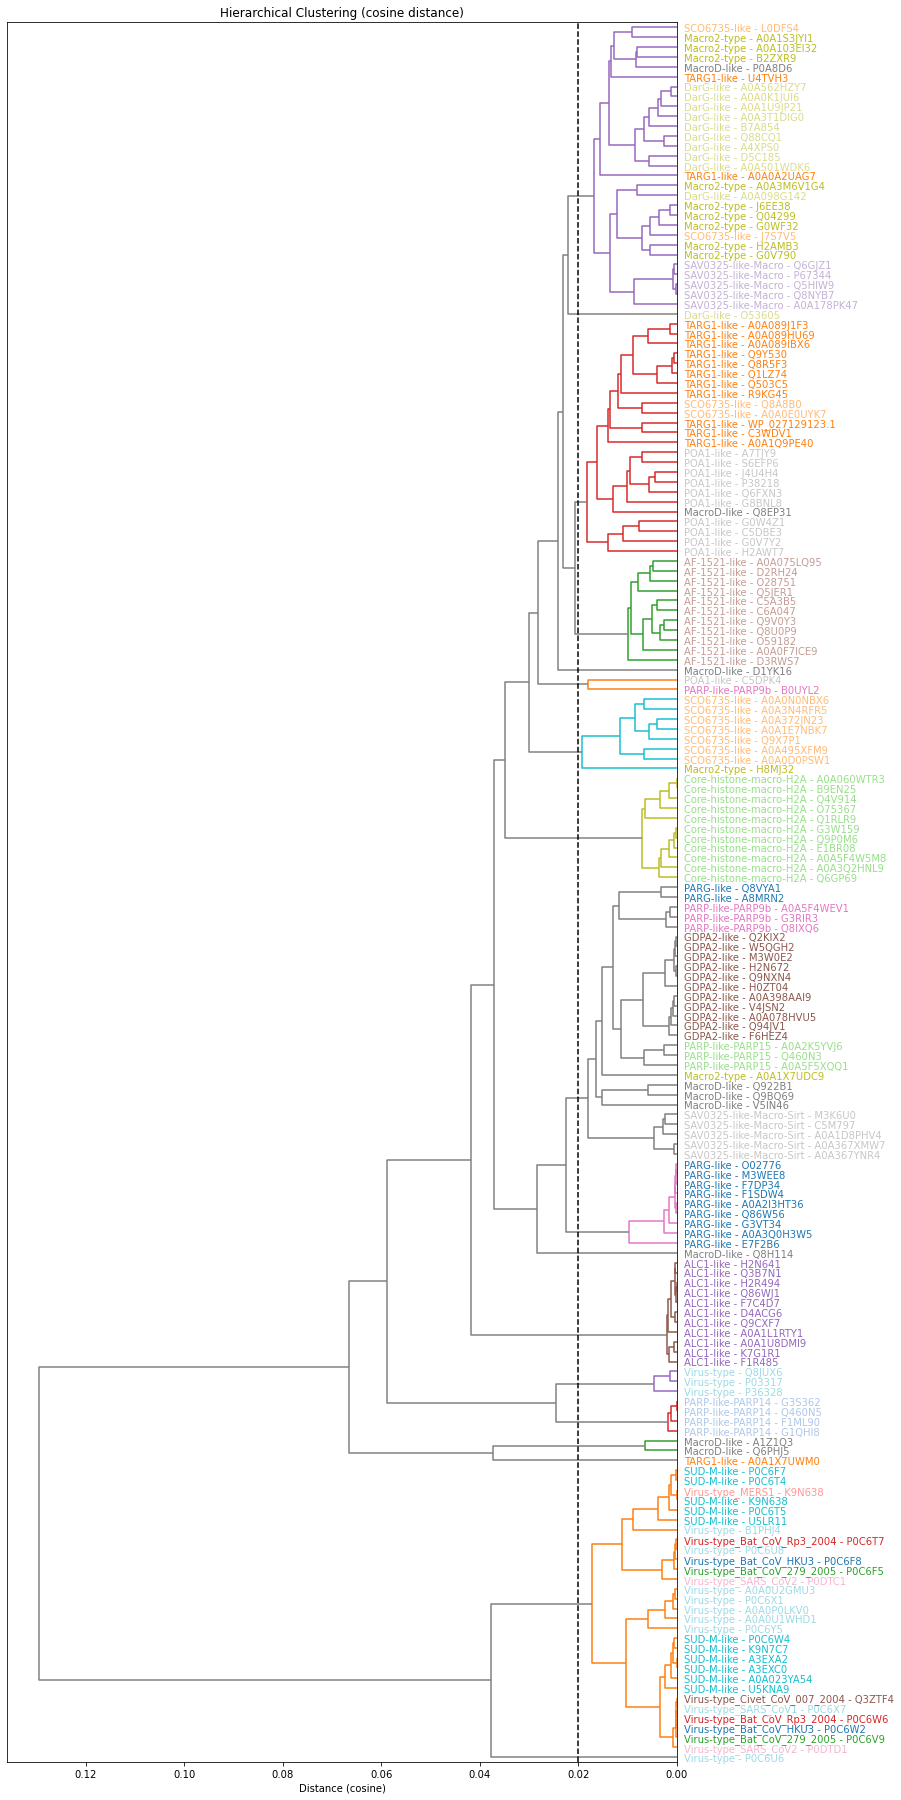

In [47]:
dendogram_cosine = hierarchical_clustering(embs, labels, codes, distance="cosine", method='average',
                        threshold=0.02, orientation="left", figsize=(12,32))

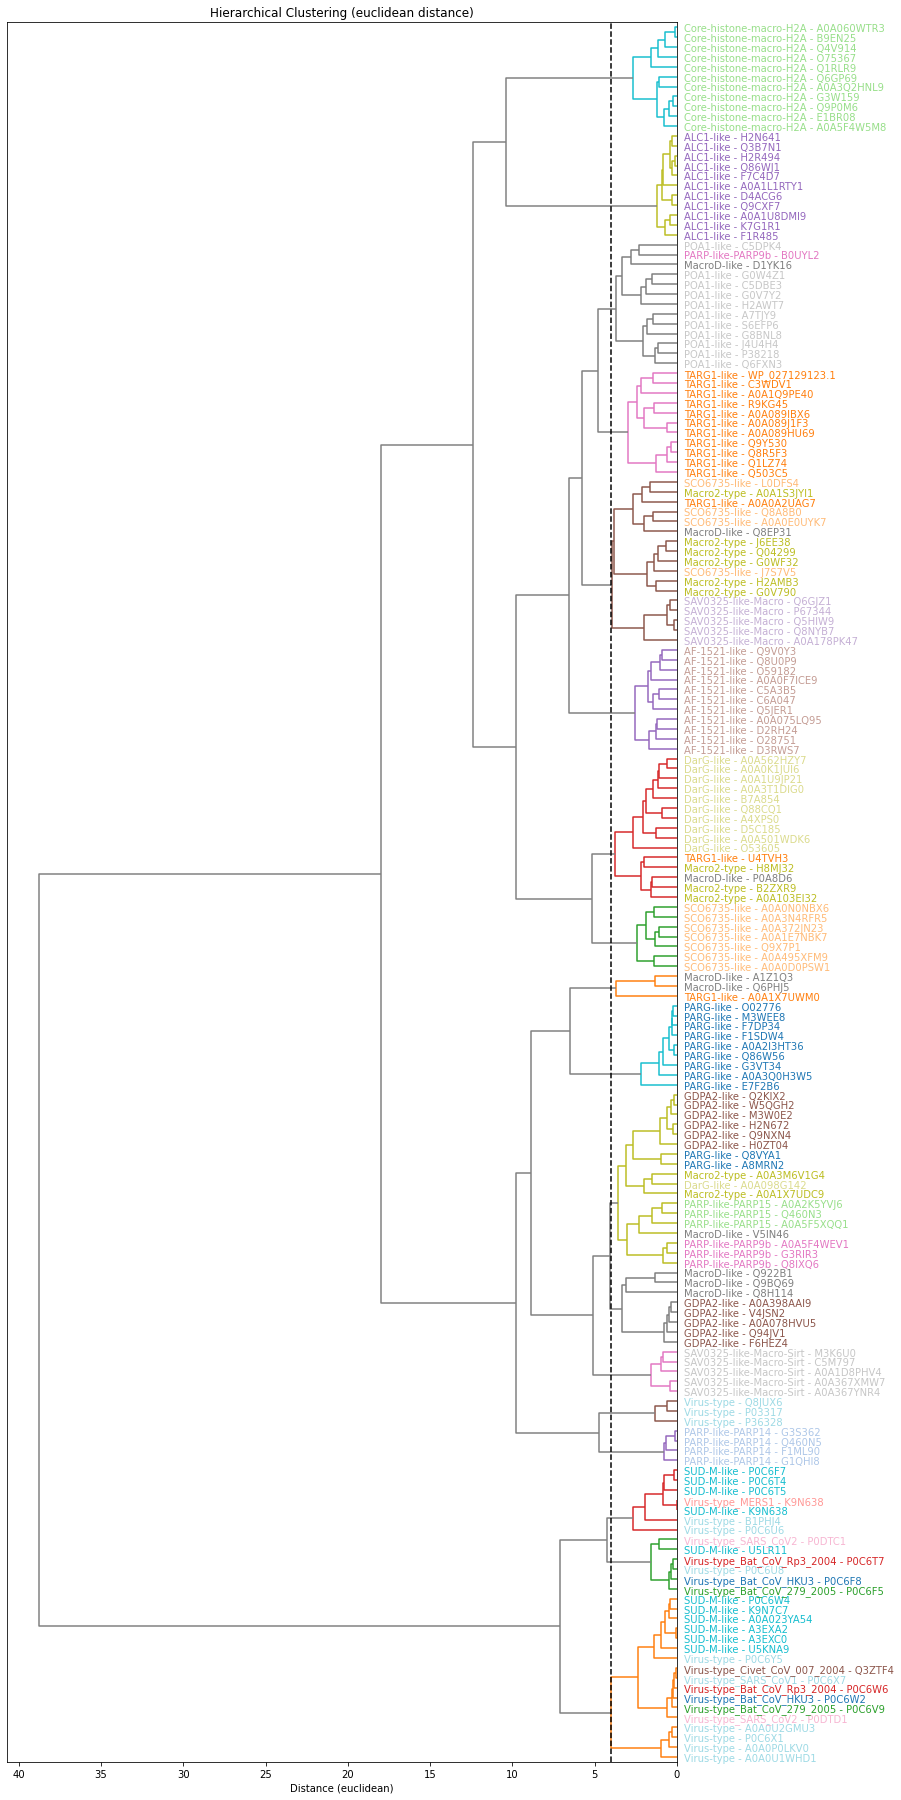

In [48]:
dendogram_euclidean = hierarchical_clustering(embs, labels, codes, distance="euclidean", method='ward',
                        threshold=4, orientation="left", figsize=(12,32))

## [Save dendrogram to newick format](https://stackoverflow.com/questions/28222179/save-dendrogram-to-newick-format)

In [50]:
def getNewick(node, newick, parentdist, leaf_names):
    if node.is_leaf():
        return "%s:%.2f%s" % (leaf_names[node.id], parentdist - node.dist, newick)
    else:
        if len(newick) > 0:
            newick = "):%.2f%s" % (parentdist - node.dist, newick)
        else:
            newick = ");"
        newick = getNewick(node.get_left(), newick, node.dist, leaf_names)
        newick = getNewick(node.get_right(), ",%s" % (newick), node.dist, leaf_names)
        newick = "(%s" % (newick)
        return newick

In [55]:
newick_cosine    = getNewick(dendogram_cosine,    "", tree.dist, leaf_names=labels + " - " + codes)
newick_euclidean = getNewick(dendogram_euclidean, "", tree.dist, leaf_names=labels + " - " + codes)

## Visualizar Newick

In [56]:
from ete3 import Tree

In [57]:
t = Tree(newick_cosine)

In [58]:
print(t.get_ascii(show_internal=False))


                                                   /-SCO6735-like - L0DFS4
                                                /-|
                                               |   \-Macro2-type - A0A1S3JYI1
                                             /-|
                                            |  |      /-Macro2-type - A0A103EI32
                                            |  |   /-|
                                          /-|   \-|   \-Macro2-type - B2ZXR9
                                         |  |     |
                                         |  |      \-MacroD-like - P0A8D6
                                         |  |
                                         |   \-TARG1-like - U4TVH3
                                         |
                                         |                  /-DarG-like - A0A562HZY7
                                         |               /-|
                                       /-|            /-|   \-DarG-like - A0A0K1JUI6
                   